<a href="https://colab.research.google.com/github/dolmani38/BLE-signal-collision-simulation/blob/main/simulation_0626.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BLE Advertisement packet collision simulation

# 이하, 3개 모델로 Simulation
1. node 증가에 따른 선형 충돌률 증가 모델 (자체 고안)
2. poisson 분포를 적용한 논문의 모델
3. poisson 모델에 대해 순수 이론만 바탕으로한 모델

## 1. node 증가에 따른 선형 충돌률 증가 모델 (자체 고안)

* 2 signal의 충돌 확률을 고려한다.
* Signal은 5000ms 간격, 2ms 동안 송출
* 2ms 내 3개 channel(37,38,39)로 각 1회 총 3회 순차적 송출 (advertising event)
* 이에 따른 2 signal의 충돌 확률은 2/5000 * (1/1.4)^3 으로 생각 가능
* 여기서 1/1.4는 동일 channel이 충돌할 확률
* 2 signal의 충돌 확률을 p(2) = a 라고 한다면 

* 3 signal의 충돌은 1,2번 충돌, 1,3번 충돌, 2,3번 충돌, 1,2,3 모두 충돌의 경우의 수를 고려 가능
* 이상의 경우, 3a + a^2 으로 표현 가능
 * p(3) = 2a + a^2 + p(2)
* 여기서 a^2은, 1,2번이 충돌과 여기에 3번이 동시에 충돌될 확률에 해당
* 4 Signal의 경우 같은 맥락으로 
 * 1,2 / 1,3 / 1,4 / 1,2,3 / 1,3,4 / 1,2,3,4
 * 2,3 / 2,4 / 2,3,4
 * 3,4
 * p(4) = 3a + 2a^2 + a^3 + p(3) 
        = 3a + 2a^2 + a^3 + 3a + a^2 
        = 6a + 3a^2 + a^3
* 5 Signal의 경우
 * 1,2 / 1,3 / 1,4 / 1,5 / 1,2,3 / 1,3,4 / 1,4,5 / 1,2,3,4 / 1,2,3,5 / 1,2,3,4,5
 * p(5) = 4a + 3a^2 + 2a^3 + a^4 + p(4)
        = 4a + 3a^2 + 2a^3 + a^4 + 6a + 3a^2 + a^3
        = 10a + 6a^2 + 3a^3 + a^4

* 수식 입력 참고 (https://colab.research.google.com/github/datascienceschool/book/blob/master/ds/02%20mathematics/04.01%20%ED%95%A8%EC%88%98.ipynb)

* 참고 논문 (https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=8443321)

### n Signal collision function

In [ ]:
0.376 * 3 + 0.02 * 2

1.1680000000000001

2 Signal collision probability

* advInterval = 5000ms
* advDelay = 0~10ms
* advertising event (dAE) = dp (0.376ms) * 3 + dg (0.02ms) * 2 = 1.1680
* 2 Signal collision probability = 2*dp/(advInterval + advDelay)

$$
\begin{align}
P_c(2) = \dfrac{2d_{.p}}{advInterval + advDelay}
\tag{1}
\end{align}
$$


n Signal collision fuction

$$
\begin{align}
P_c(n) = \sum_{k=2}^n (k-1)P_c(2)^{n-k+1} + p_c(n-1)
\tag{2}
\end{align}
$$

$$
\begin{align}
P_c(n) = \sum_{k=2}^n (k-1)P_c(2)
\tag{3}
\end{align}
$$

In [ ]:
Pc(3) = (2-1)Pc + (3-1)Pc = 3pc 
Pc(4) = (2-1)Pc + (3-1)Pc + (4-1)Pc = 1+2+3 = 6
 

In [ ]:
# 2 Signal collision probability

advInterval = 5000
advDelay = 5
dp = 0.376

Pc = 2*dp / (advInterval + advDelay)

Pc

0.00015024975024975024

In [255]:
from typing import MappingView
def collision_fuction(signal_count=100, default_prob = Pc):
    term1 = 0.0
    if signal_count == 1:
        return 0.0

    if signal_count == 2:
        return default_prob

    for k in range(2,signal_count+1):
        term1 = term1 + (k-1)*default_prob #**(signal_count-k+1) 

    return term1 #+ collision_fuction(signal_count-1)


In [281]:
import matplotlib.pyplot as plt

def collision_simulation(signal_count=100, default_prob = Pc):
    collision = []
    collision.append(0.0)
    collision.append(0.0)
    for i in range(2,signal_count+1):
        c = collision_fuction(signal_count=i,default_prob = Pc)
        if (c < signal_count):
            collision.append(c/(i-1))
        else:
            print(f"{i}개 운영의 경우, {collision[-1]*i:.4f}개의 충돌 예측. 즉, 상시 충돌 상황.")
            break

    print(f"{signal_count}개 운영의 경우, {collision[-1]*signal_count:.4f}개의 충돌 예측. 충돌 확률 {(collision[-1]*100):.4f}%")
    plt.plot(collision,label='self model')
    plt.legend()
    return collision

10개 운영의 경우, 0.0075개의 충돌 예측. 충돌 확률 0.0751%


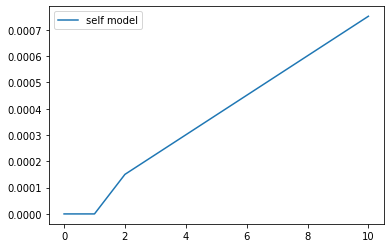

In [282]:
self_model_collision = collision_simulation(signal_count=10)

100개 운영의 경우, 0.7512개의 충돌 예측. 충돌 확률 0.7512%


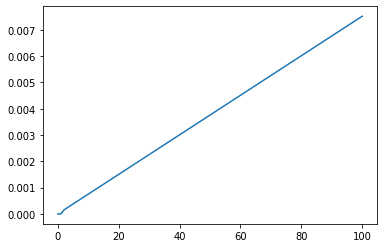

In [262]:

self_model_collision = collision_simulation(signal_count=100)


500개 운영의 경우, 18.7812개의 충돌 예측. 충돌 확률 3.7562%


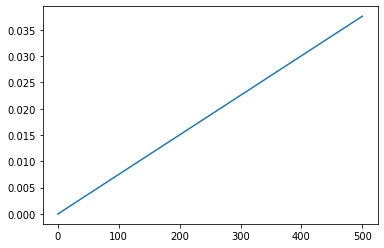

In [263]:

self_model_collision = collision_simulation(signal_count=500)

1000개 운영의 경우, 75.1249개의 충돌 예측. 충돌 확률 7.5125%


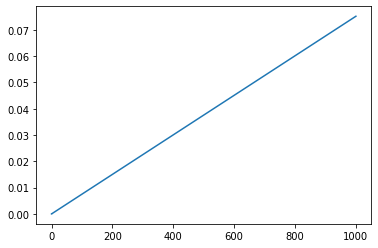

In [264]:
self_model_collision = collision_simulation(signal_count=1000)

2000개 운영의 경우, 300.4995개의 충돌 예측. 충돌 확률 15.0250%


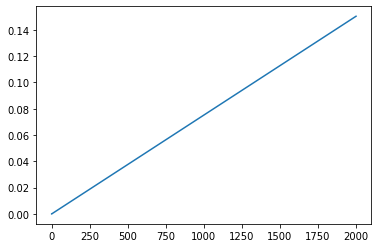

In [265]:
self_model_collision = collision_simulation(signal_count=2000)

5000개 운영의 경우, 1878.1219개의 충돌 예측. 충돌 확률 37.5624%


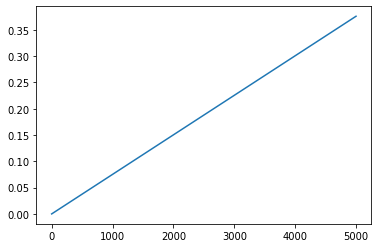

In [266]:
self_model_collision = collision_simulation(signal_count=5000)

10000개 운영의 경우, 7512.4875개의 충돌 예측. 충돌 확률 75.1249%


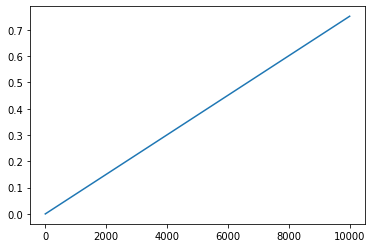

In [267]:
self_model_collision = collision_simulation(signal_count=10000)

16317개 운영의 경우, 20000.3582개의 충돌 예측. 즉, 상시 충돌 상황.
20000개 운영의 경우, 24514.7493개의 충돌 예측. 충돌 확률 122.5737%


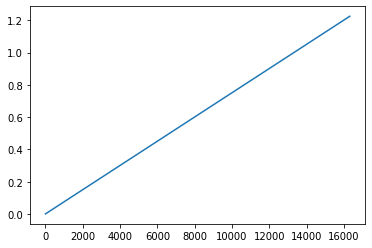

In [268]:
self_model_collision = collision_simulation(signal_count=20000)

##2. poisson 분포를 적용한 논문의 모델

* 참고 논문 (https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=8443321)

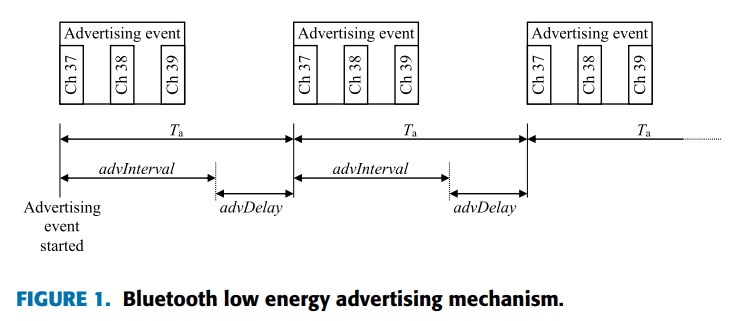

### IV. BLUETOOTH LOW ENERGY COLLISION ANALYSIS
In this section, we analyze the probability of packet collisions. In order to do the collision analysis, we initially
make a number of assumptions as follows: <br>
    1. advertising nodes attempt to transmit according to a Poisson distribution;<br>
    2. advDelay is considered constant (as expectation of random delays); <br>
    3. advertising channel packet duration (dp) for all three advertising channels (channel index = 37, 38, 39) is fixed; <br>
    4. the time duration that an advertiser requires to change its channel (dg) is constant; <br>
    5. for simulation, we did not consider any distortions from the channel; <br>
    6. any number of packets that collide in one time interval is considered one collision.<br>


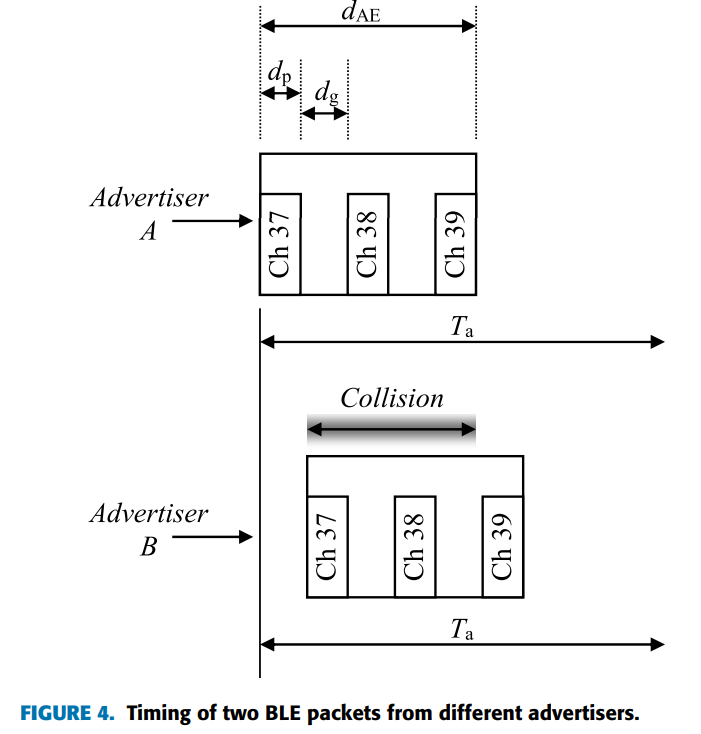

### Poisson distribution model

$$
\begin{align}
P_c(n) = 1 - e^{-n \lambda 2d_p }
\tag{4}
\end{align}
$$

\begin{align}
\lambda = \dfrac{1}{advInterval + advDelay}
\tag{5}
\end{align}

* 근데, 왜 2 dp ???
* -n * lambda * 2 * dp 에서 - 의 이유???

In [ ]:
sys.float_info.epsilon

2.220446049250313e-16

In [245]:
# Poisson distribution model

import sys


advInterval =5000
advDelay = 5
lambda1 = 1/(advInterval+advDelay)
print(lambda1)
# https://infocenter.nordicsemi.com/index.jsp?topic=%2Fsds_s140%2FSDS%2Fs1xx%2Fble_processor_avail_interrupt_latency%2Fble_broadcaster_performance.html
# advertising 175us ???
dp = 0.376  # 12us

def poisson_function(node_count=100):
    return  1-sys.float_info.epsilon**(-node_count * lambda1 * 2 * dp)

0.0001998001998001998


In [246]:

def collision_simulation2(signal_count=100):
    collision = []
    #collision.append(0.0)
    #collision.append(0.0)
    for i in range(0,signal_count):
        c = poisson_function(node_count=i)
        if (c < signal_count):
            collision.append(c)
        else:
            print(f"{i}개 운영의 경우, {collision[-1]:.4f}개의 충돌 예측. 즉, 상시 충돌 상황.")
            break

    print(f"{signal_count}개 운영의 경우, {collision[-1]*i:.4f}개의 충돌 예측. 충돌 확률 {collision[-1]*100:.4f}%")
    plt.plot(collision)

100개 운영의 경우, -70.2301개의 충돌 예측. 충돌 확률 -70.9395%


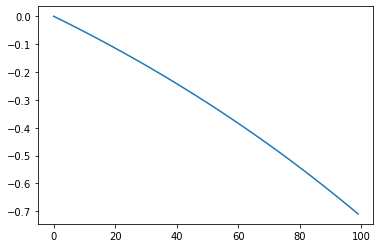

In [ ]:
collision_simulation2(signal_count=100)

500개 운영의 경우, -6943.5254개의 충돌 예측. 충돌 확률 -1391.4881%


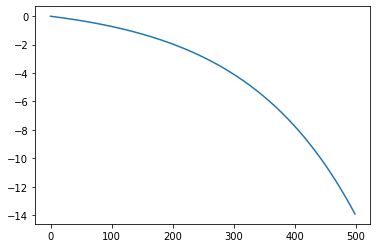

In [ ]:
collision_simulation2(signal_count=500)

1000개 운영의 경우, -222438.9774개의 충돌 예측. 충돌 확률 -22266.1639%


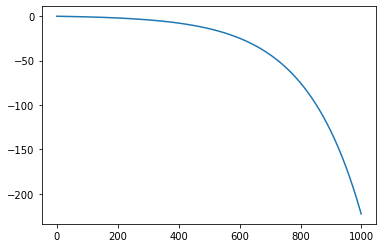

In [ ]:
collision_simulation2(signal_count=1000)

### 일단 결과에 맞춘다...

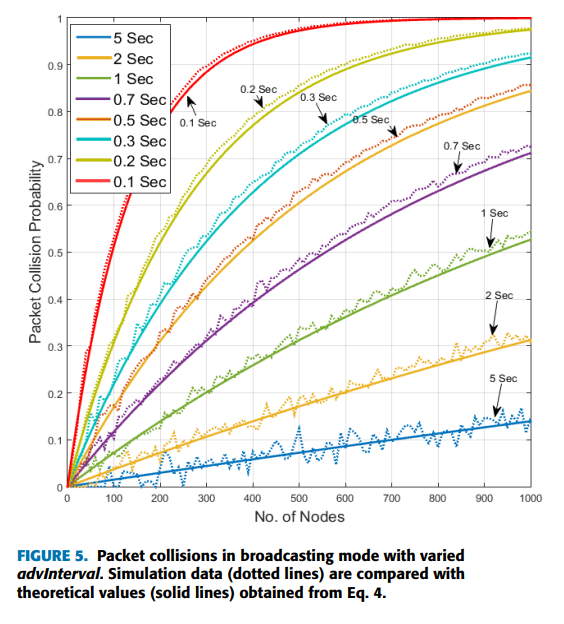

In [309]:
# Poisson distribution model

import sys

def poisson_function2(node_count=100,advInterval =5000):
    
    advDelay = 5
    #lambda1 = 1/(advInterval+advDelay)
    alpha = -12/376
    #print(lambda1)
    # https://infocenter.nordicsemi.com/index.jsp?topic=%2Fsds_s140%2FSDS%2Fs1xx%2Fble_processor_avail_interrupt_latency%2Fble_broadcaster_performance.html
    # advertising 175us ???
    dp = 0.376  # 12us    
    return  1-sys.float_info.epsilon**(-node_count * lambda1 * 2 * dp * alpha)

In [307]:

def collision_simulation3(signal_count=100,advInterval =5000):
    collision = []
    #collision.append(0.0)
    #collision.append(0.0)
    for i in range(0,signal_count):
        c = poisson_function2(node_count=i,advInterval =advInterval)
        if (c < signal_count):
            collision.append(c)
        else:
            print(f"{i}개 운영의 경우, {collision[-1]:.4f}개의 충돌 예측. 즉, 상시 충돌 상황.")
            break

    print(f"{signal_count}개 운영의 경우, {collision[-1]*i:.4f}개의 충돌 예측. 충돌 확률 {collision[-1]*100:.4f}%")
    plt.plot(collision,label='poisson model (paper)')
    plt.legend()
    return collision

100개 운영의 경우, 55.2057개의 충돌 예측. 충돌 확률 55.7633%


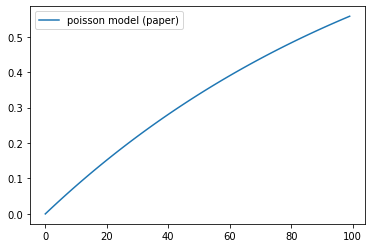

In [308]:
poisson_model_2 = collision_simulation3(signal_count=100,advInterval = 100)

1000개 운영의 경우, 998.7338개의 충돌 예측. 충돌 확률 99.9734%


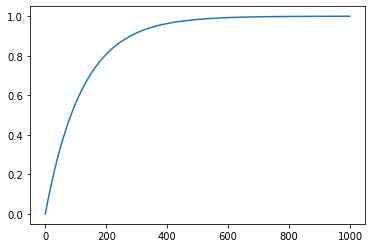

In [ ]:
poisson_model_2 =collision_simulation3(signal_count=1000,advInterval = 100)

100개 운영의 경우, 1.6796개의 충돌 예측. 충돌 확률 1.6965%


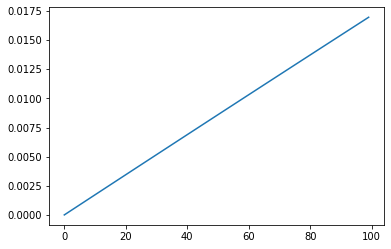

In [ ]:
poisson_model_2 =collision_simulation3(signal_count=100)

500개 운영의 경우, 41.2329개의 충돌 예측. 충돌 확률 8.2631%


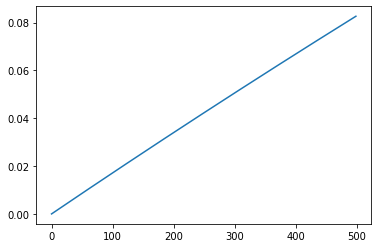

In [ ]:
poisson_model_2 =collision_simulation3(signal_count=500)

1000개 운영의 경우, 158.4210개의 충돌 예측. 충돌 확률 15.8580%


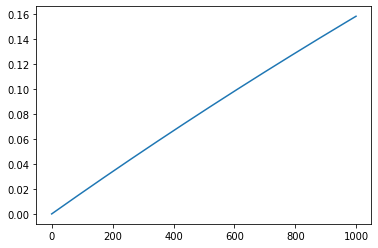

In [ ]:
poisson_model_2 =collision_simulation3(signal_count=1000)

5000개 운영의 경우, 2892.0799개의 충돌 예측. 충돌 확률 57.8532%


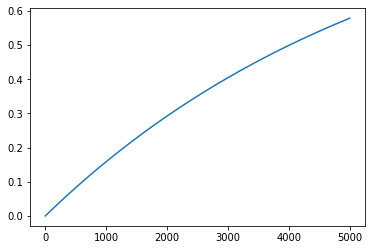

In [ ]:
poisson_model_2 =collision_simulation3(signal_count=5000)

10000개 운영의 경우, 8223.1291개의 충돌 예측. 충돌 확률 82.2395%


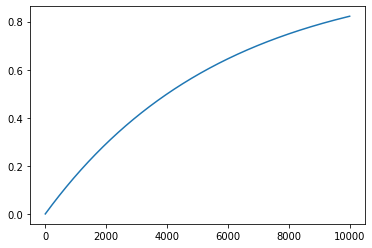

In [ ]:
poisson_model_2 =collision_simulation3(signal_count=10000)

20000개 운영의 경우, 19368.2709개의 충돌 예측. 충돌 확률 96.8462%


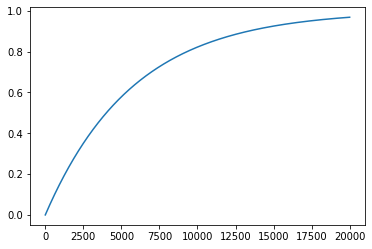

In [ ]:
poisson_model_2 =collision_simulation3(signal_count=20000)

## poisson 모델에 대해 순수 이론만 바탕으로한 모델

참고 : https://en.wikipedia.org/wiki/Poisson_distribution <br>
참고 : https://www.statology.org/poisson-distribution-python/

In [250]:

from scipy.stats import poisson
# https://www.statology.org/poisson-distribution-python/
# Example 3: Probability Greater than Some Value

advInterval =5000
advDelay = 5
lambda1 = 1/(advInterval+advDelay)
print(lambda1)
# https://infocenter.nordicsemi.com/index.jsp?topic=%2Fsds_s140%2FSDS%2Fs1xx%2Fble_processor_avail_interrupt_latency%2Fble_broadcaster_performance.html
# advertising 175us ???
dp = 0.376  # 12us

def poisson_function9(node_count=100):
    #node_count = 1000
    mu = node_count * lambda1 * 2 * dp 
    k=1
    #calculate probability
    p = 1- poisson.cdf(k=k, mu=mu)
    #p = 1-mu*sys.float_info.epsilon**-mu
    return p

0.0001998001998001998


In [285]:

def collision_simulation9(signal_count=100):
    collision = []
    #collision.append(0.0)
    #collision.append(0.0)
    for i in range(0,signal_count):
        c = poisson_function9(node_count=i)
        if (c < signal_count):
            collision.append(c)
        else:
            print(f"{i}개 운영의 경우, {collision[-1]*i:.4f}개의 충돌 예측. 즉, 상시 충돌 상황.")
            break

    print(f"{signal_count}개 운영의 경우, {collision[-1]*i:.4f}개의 충돌 예측. 충돌 확률 {collision[-1]*100:.4f}%")
    plt.plot(collision,label='poisson model (self)')
    plt.legend()
    return collision

100개 운영의 경우, 0.0108개의 충돌 예측. 충돌 확률 0.0110%


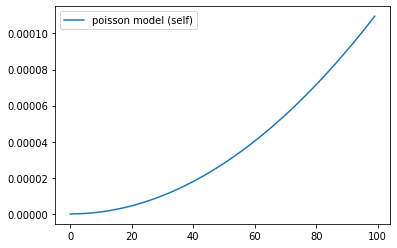

In [286]:
poisson_model_1 = collision_simulation9(signal_count=100)

1000개 운영의 경우, 10.1885개의 충돌 예측. 충돌 확률 1.0199%


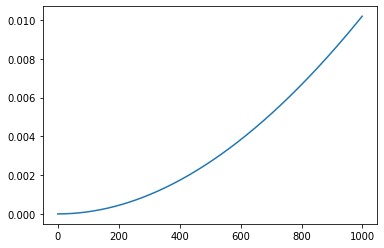

In [253]:
poisson_model_1 = collision_simulation9(signal_count=1000)

5000개 운영의 경우, 868.5651개의 충돌 예측. 충돌 확률 17.3748%


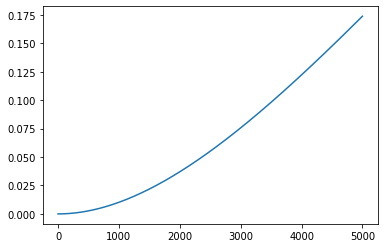

In [ ]:
poisson_model_1 = collision_simulation9(signal_count=5000)

10000개 운영의 경우, 4429.1561개의 충돌 예측. 충돌 확률 44.2960%


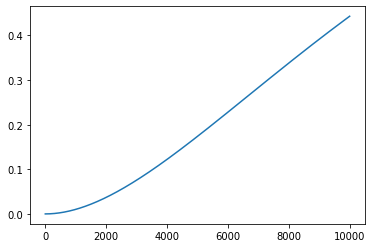

In [ ]:
poisson_model_1 = collision_simulation9(signal_count=10000)

20000개 운영의 경우, 16030.6820개의 충돌 예측. 충돌 확률 80.1574%


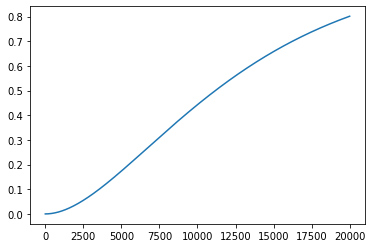

In [ ]:
poisson_model_1 = collision_simulation9(signal_count=20000)

30000개 운영의 경우, 28177.0562개의 충돌 예측. 충돌 확률 93.9267%


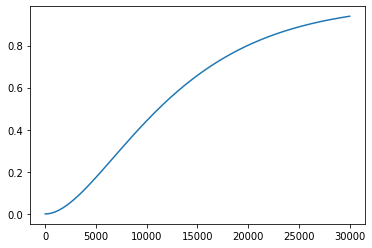

In [ ]:
poisson_model_1 = collision_simulation9(signal_count=30000)

# 이상의 3개 모델 비교

10개 운영의 경우, 0.0075개의 충돌 예측. 충돌 확률 0.0751%
10개 운영의 경우, 0.0000개의 충돌 예측. 충돌 확률 0.0001%
10개 운영의 경우, 0.0140개의 충돌 예측. 충돌 확률 0.1554%


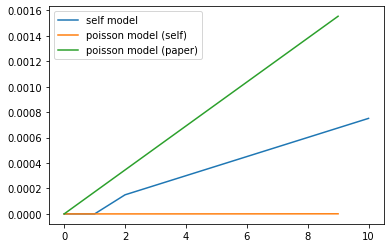

In [287]:
self_model_collision = collision_simulation(signal_count=10)
poisson_model_1 = collision_simulation9(signal_count=10)
poisson_model_2 = collision_simulation3(signal_count=10)

100개 운영의 경우, 0.7512개의 충돌 예측. 충돌 확률 0.7512%
100개 운영의 경우, 0.0108개의 충돌 예측. 충돌 확률 0.0110%
100개 운영의 경우, 1.6796개의 충돌 예측. 충돌 확률 1.6965%


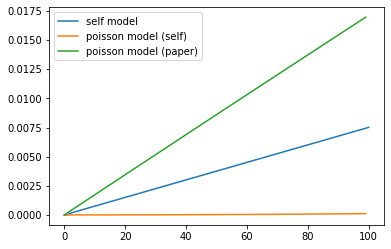

In [288]:
self_model_collision = collision_simulation(signal_count=100)
poisson_model_1 = collision_simulation9(signal_count=100)
poisson_model_2 = collision_simulation3(signal_count=100)

1000개 운영의 경우, 75.1249개의 충돌 예측. 충돌 확률 7.5125%
1000개 운영의 경우, 10.1885개의 충돌 예측. 충돌 확률 1.0199%
1000개 운영의 경우, 158.4210개의 충돌 예측. 충돌 확률 15.8580%


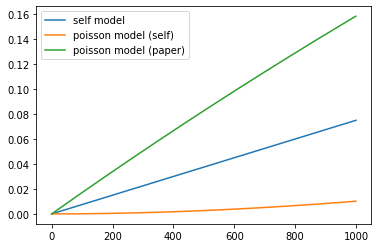

In [289]:
self_model_collision = collision_simulation(signal_count=1000)
poisson_model_1 = collision_simulation9(signal_count=1000)
poisson_model_2 = collision_simulation3(signal_count=1000)

10000개 운영의 경우, 7512.4875개의 충돌 예측. 충돌 확률 75.1249%
10000개 운영의 경우, 4429.1561개의 충돌 예측. 충돌 확률 44.2960%
10000개 운영의 경우, 8223.1291개의 충돌 예측. 충돌 확률 82.2395%


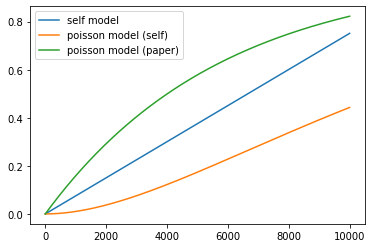

In [290]:
self_model_collision = collision_simulation(signal_count=10000)
poisson_model_1 = collision_simulation9(signal_count=10000)
poisson_model_2 = collision_simulation3(signal_count=10000)

16317개 운영의 경우, 20000.3582개의 충돌 예측. 즉, 상시 충돌 상황.
20000개 운영의 경우, 24514.7493개의 충돌 예측. 충돌 확률 122.5737%
20000개 운영의 경우, 16030.6820개의 충돌 예측. 충돌 확률 80.1574%
20000개 운영의 경우, 19368.2709개의 충돌 예측. 충돌 확률 96.8462%


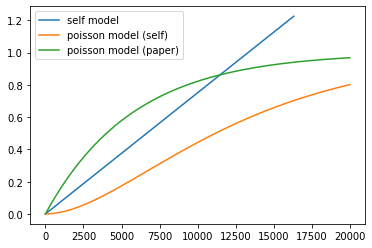

In [291]:
self_model_collision = collision_simulation(signal_count=20000)
poisson_model_1 = collision_simulation9(signal_count=20000)
poisson_model_2 = collision_simulation3(signal_count=20000)

30000개 운영의 경우, 28177.0562개의 충돌 예측. 충돌 확률 93.9267%
30000개 운영의 경우, 29830.9954개의 충돌 예측. 충돌 확률 99.4400%


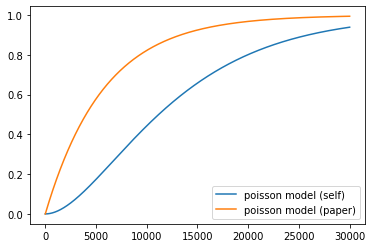

In [292]:
poisson_model_1 = collision_simulation9(signal_count=30000)
poisson_model_2 = collision_simulation3(signal_count=30000)

# 소결

한공장에 전체적으로 적용하는것을 가정, 1만개를 Target <br>
전파는 공장내 회절, 산란등을 통하여 특정 지역을 구분하지 않을 것 <br>
신호가 약해져서 정보 전달이 어려워 져도, 간섭의 영향은 남아 있을 것 <br>
즉, 공장내 설치된 Device는 전체가 상호 간섭의 영향 대상이 되는 것으로 간주 필요<br>

1만개를 Target으로 collision의 목표 확률을 설정하고 이에 필요한 알고리즘의 구현 필요.<br>
현재의 Simulation은 min 44% 에서 Max 82%의 충돌이 예상됨.<br>

현재 상태로 적절한가?

# Advertisement 충돌 회피 방안 

1. advInterval 의 증가
2. advertising channels의 순서 random화 (가능?)

## advInterval 증가

* 5000ms -> 10000ms


In [296]:
advInterval =10000
advDelay = 5
lambda1 = 1/(advInterval+advDelay)
print(lambda1)
dp = 0.376  # 12us
Pc = 2*dp / (advInterval + advDelay)

9.995002498750625e-05


10000개 운영의 경우, 3758.1209개의 충돌 예측. 충돌 확률 37.5812%
10000개 운영의 경우, 1738.9006개의 충돌 예측. 충돌 확률 17.3907%
10000개 운영의 경우, 5786.9217개의 충돌 예측. 충돌 확률 57.8750%


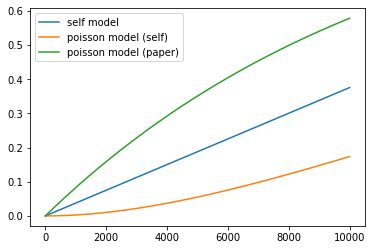

In [297]:
self_model_collision = collision_simulation(signal_count=10000)
poisson_model_1 = collision_simulation9(signal_count=10000)
poisson_model_2 = collision_simulation3(signal_count=10000,advInterval =10000)

## advertising channels의 순서 random화 (가능?)

* (channel index = 37, 38, 39) -> random

In [301]:
advInterval =5000
advDelay = 5
lambda1 = 1/(advInterval+advDelay) * (1/3)**3
print(lambda1)
dp = 0.376  # 12us
Pc = 2*dp * lambda1

7.400007400007398e-06


10000개 운영의 경우, 278.2403개의 충돌 예측. 충돌 확률 2.7824%
10000개 운영의 경우, 14.9165개의 충돌 예측. 충돌 확률 0.1492%
10000개 운영의 경우, 619.9555개의 충돌 예측. 충돌 확률 6.2002%


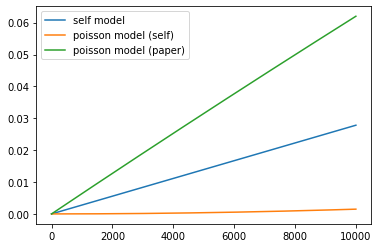

In [310]:
self_model_collision = collision_simulation(signal_count=10000)
poisson_model_1 = collision_simulation9(signal_count=10000)
poisson_model_2 = collision_simulation3(signal_count=10000,advInterval =5000)

## advInterval 증가 + channel index random

In [311]:
advInterval =10000
advDelay = 5
lambda1 = 1/(advInterval+advDelay) * (1/3)**3
print(lambda1)
dp = 0.376  # 12us
Pc = 2*dp * lambda1

3.701852777315045e-06


10000개 운영의 경우, 139.1897개의 충돌 예측. 충돌 확률 1.3919%
10000개 운영의 경우, 3.8025개의 충돌 예측. 충돌 확률 0.0380%
10000개 운영의 경우, 315.0924개의 충돌 예측. 충돌 확률 3.1512%


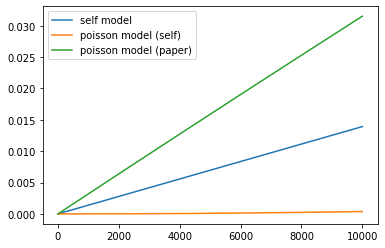

In [312]:
self_model_collision = collision_simulation(signal_count=10000)
poisson_model_1 = collision_simulation9(signal_count=10000)
poisson_model_2 = collision_simulation3(signal_count=10000,advInterval =10000)

## 결론
* 두개 방안을 모두 적용하면, 논문의 이론대로도 3.5%의 충돌 예상.